**Loading the dataset and necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV,KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [2]:
cars_data = pd.read_csv('/content/car_price.csv',index_col=0)

**EDA and Data Preprocessing**

In [3]:
df = cars_data.copy()
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats
0,Jeep Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats
1,Renault Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats
2,Toyota Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats
3,Honda Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats
4,Volkswagen Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats


In [4]:
df.dtypes

car_name               object
car_prices_in_rupee    object
kms_driven             object
fuel_type              object
transmission           object
ownership              object
manufacture             int64
engine                 object
Seats                  object
dtype: object

In [5]:
temp = df.columns.copy()
temp = list(temp)
temp.remove('manufacture')
temp

['car_name',
 'car_prices_in_rupee',
 'kms_driven',
 'fuel_type',
 'transmission',
 'ownership',
 'engine',
 'Seats']

In [6]:
for x in temp:
  df[x] = df[x].astype('string')
df.dtypes

car_name               string
car_prices_in_rupee    string
kms_driven             string
fuel_type              string
transmission           string
ownership              string
manufacture             int64
engine                 string
Seats                  string
dtype: object

In [7]:
print("Data shape: " + str(df.shape))

Data shape: (5512, 9)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5512 entries, 0 to 5511
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   car_name             5512 non-null   string
 1   car_prices_in_rupee  5512 non-null   string
 2   kms_driven           5512 non-null   string
 3   fuel_type            5512 non-null   string
 4   transmission         5512 non-null   string
 5   ownership            5512 non-null   string
 6   manufacture          5512 non-null   int64 
 7   engine               5512 non-null   string
 8   Seats                5512 non-null   string
dtypes: int64(1), string(8)
memory usage: 430.6 KB


In [9]:
df[["brand", "car_name"]] = df["car_name"].str.split(" ", 1,expand=True)
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand
0,Compass 2.0 Longitude Option BSIV,10.03 Lakh,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats,Jeep
1,Duster RXZ Turbo CVT,12.83 Lakh,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats,Renault
2,Camry 2.5 G,16.40 Lakh,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats,Toyota
3,Jazz VX CVT,7.77 Lakh,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats,Honda
4,Polo 1.2 MPI Highline,5.15 Lakh,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats,Volkswagen


In [10]:
df.dtypes

car_name               string
car_prices_in_rupee    string
kms_driven             string
fuel_type              string
transmission           string
ownership              string
manufacture             int64
engine                 string
Seats                  string
brand                  string
dtype: object

In [11]:
df.isna().sum()

car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
brand                  0
dtype: int64

In [12]:
unique_values = set([x[1] for x in list(df['car_prices_in_rupee'].str.split(" "))])
print("Unique values:", unique_values)

Unique values: {'Crore', 'Lakh', ''}


In [13]:
def price_conversion(price):
  if "Lakh" in str(price):
    new_price = int(round(float(str(price).split(' ')[0]),2)*100000)
    return new_price
  elif "Crore" in str(price):
    new_price = int(round(float(str(price).split(' ')[0]),2)*10000000)
    return new_price
  else:
    return int(str(price).replace(',', ''))

In [14]:
df['car_prices_in_rupee'] = df['car_prices_in_rupee'].apply(price_conversion)
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand
0,Compass 2.0 Longitude Option BSIV,1002999,"86,226 kms",Diesel,Manual,1st Owner,2017,1956 cc,5 Seats,Jeep
1,Duster RXZ Turbo CVT,1283000,"13,248 kms",Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats,Renault
2,Camry 2.5 G,1639999,"60,343 kms",Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats,Toyota
3,Jazz VX CVT,777000,"26,696 kms",Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats,Honda
4,Polo 1.2 MPI Highline,515000,"69,414 kms",Petrol,Manual,1st Owner,2016,1199 cc,5 Seats,Volkswagen


In [15]:
df.dtypes

car_name               string
car_prices_in_rupee     int64
kms_driven             string
fuel_type              string
transmission           string
ownership              string
manufacture             int64
engine                 string
Seats                  string
brand                  string
dtype: object

In [16]:
def kms_conversion(dist):
  new_dist = int(str(dist).split(' ')[0].replace(',',''))
  return new_dist

In [17]:
df['kms_driven'] = df['kms_driven'].apply(kms_conversion)
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand
0,Compass 2.0 Longitude Option BSIV,1002999,86226,Diesel,Manual,1st Owner,2017,1956 cc,5 Seats,Jeep
1,Duster RXZ Turbo CVT,1283000,13248,Petrol,Automatic,1st Owner,2021,1330 cc,5 Seats,Renault
2,Camry 2.5 G,1639999,60343,Petrol,Automatic,1st Owner,2016,2494 cc,5 Seats,Toyota
3,Jazz VX CVT,777000,26696,Petrol,Automatic,1st Owner,2018,1199 cc,5 Seats,Honda
4,Polo 1.2 MPI Highline,515000,69414,Petrol,Manual,1st Owner,2016,1199 cc,5 Seats,Volkswagen


In [18]:
df.dtypes

car_name               string
car_prices_in_rupee     int64
kms_driven              int64
fuel_type              string
transmission           string
ownership              string
manufacture             int64
engine                 string
Seats                  string
brand                  string
dtype: object

In [19]:
for x in ['transmission','ownership','manufacture','engine','Seats','brand']:
  print('Unique values for ',x,':')
  print(df[x].unique())
  print('-'*40)

Unique values for  transmission :
<StringArray>
['Manual', 'Automatic']
Length: 2, dtype: string
----------------------------------------
Unique values for  ownership :
<StringArray>
['1st Owner', '2nd Owner', '3rd Owner', '4th Owner', '5th Owner', '0th Owner']
Length: 6, dtype: string
----------------------------------------
Unique values for  manufacture :
[2017 2021 2016 2018 2015 2014 2020 2019 2012 2008 2013 2022 2010 2005
 2009 2006 2011 2007 2002 2004 1998 2003 1995 2000 2001 1999]
----------------------------------------
Unique values for  engine :
<StringArray>
['1956 cc', '1330 cc', '2494 cc', '1199 cc', '1197 cc', '1498 cc', '1497 cc',
 '1368 cc', '1396 cc', '1373 cc',
 ...
  '793 cc', '1341 cc', '1390 cc', '1590 cc', '2157 cc', '3598 cc', '3200 cc',
 '3498 cc', '1332 cc', '2979 cc']
Length: 139, dtype: string
----------------------------------------
Unique values for  Seats :
<StringArray>
['5 Seats', '6 Seats', '7 Seats', '4 Seats', '8 Seats', '2 Seats']
Length: 6, dtype: 

In [20]:
df['brand'].value_counts()

Maruti           1389
Hyundai          1023
Honda             498
Mahindra          315
Mercedes-Benz     283
Tata              269
Toyota            263
BMW               172
Renault           170
Ford              168
Audi              166
Volkswagen        159
Skoda             113
Chevrolet          82
Nissan             63
MG                 62
Kia                61
Land               50
Jeep               49
Volvo              31
Jaguar             30
Datsun             25
Fiat               17
Mini               14
Porsche            10
Lexus              10
Mitsubishi          8
Maserati            5
Isuzu               4
Force               1
Premier             1
Bentley             1
Name: brand, dtype: Int64

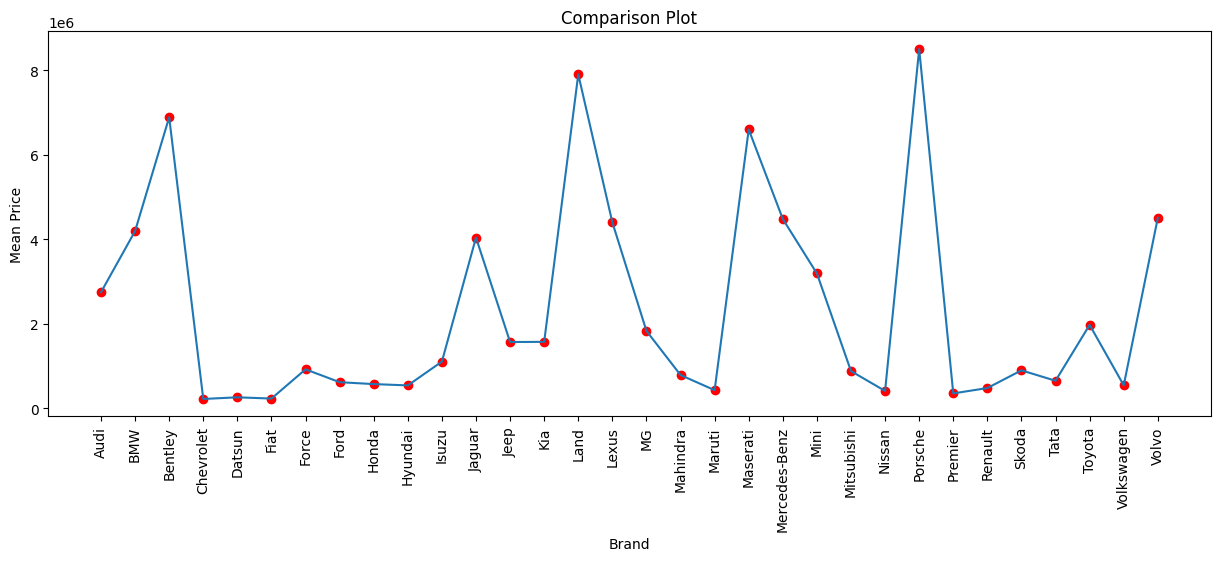

In [21]:
temp = df.groupby('brand')[['car_prices_in_rupee']]
temp = temp.agg({'car_prices_in_rupee':np.mean})
plt.figure(figsize=(15,5))
plt.plot(temp.index,temp.values)
plt.scatter(temp.index,temp.values,c='red')
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('Mean Price')
plt.title('Comparison Plot')
plt.show()

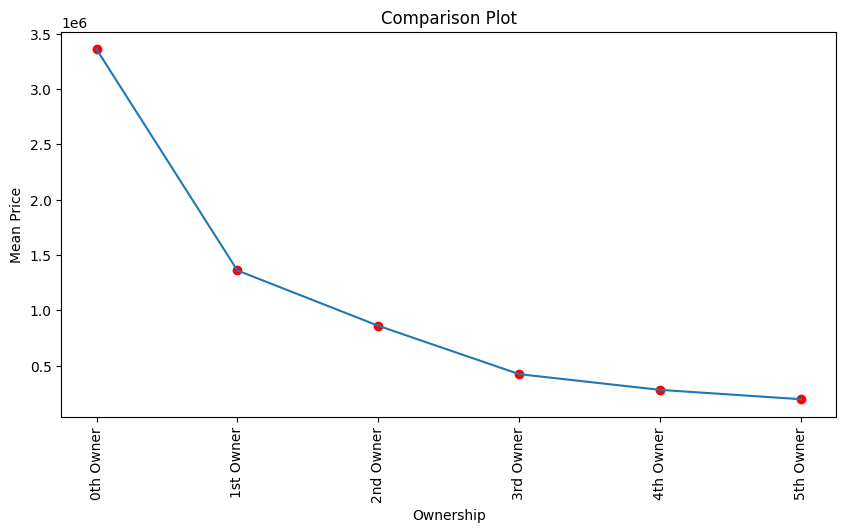

In [22]:
temp = df.groupby('ownership')[['car_prices_in_rupee']]
temp = temp.agg({'car_prices_in_rupee':np.mean})
plt.figure(figsize=(10,5))
plt.plot(temp.index,temp.values)
plt.scatter(temp.index,temp.values,c='red')
plt.xticks(rotation=90)
plt.xlabel('Ownership')
plt.ylabel('Mean Price')
plt.title('Comparison Plot')
plt.show()

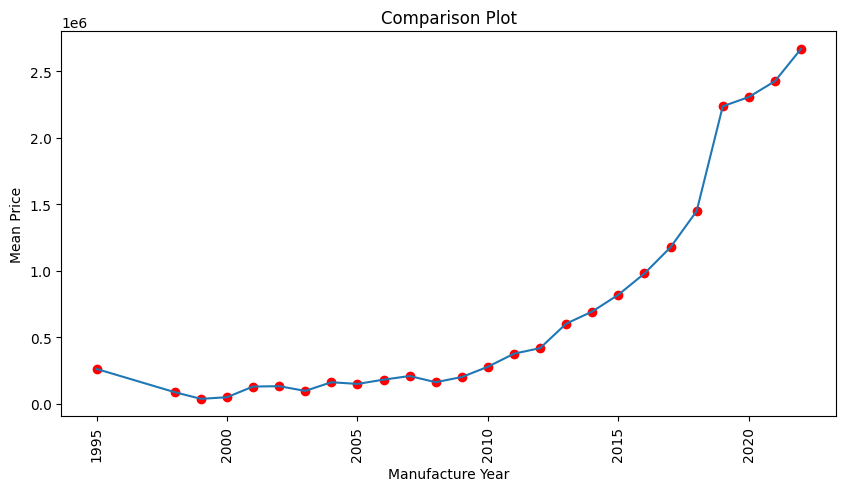

In [23]:
temp = df.groupby('manufacture')[['car_prices_in_rupee']]
temp = temp.agg({'car_prices_in_rupee':np.mean})
plt.figure(figsize=(10,5))
plt.plot(temp.index,temp.values)
plt.scatter(temp.index,temp.values,c='red')
plt.xticks(rotation=90)
plt.xlabel('Manufacture Year')
plt.ylabel('Mean Price')
plt.title('Comparison Plot')
plt.show()

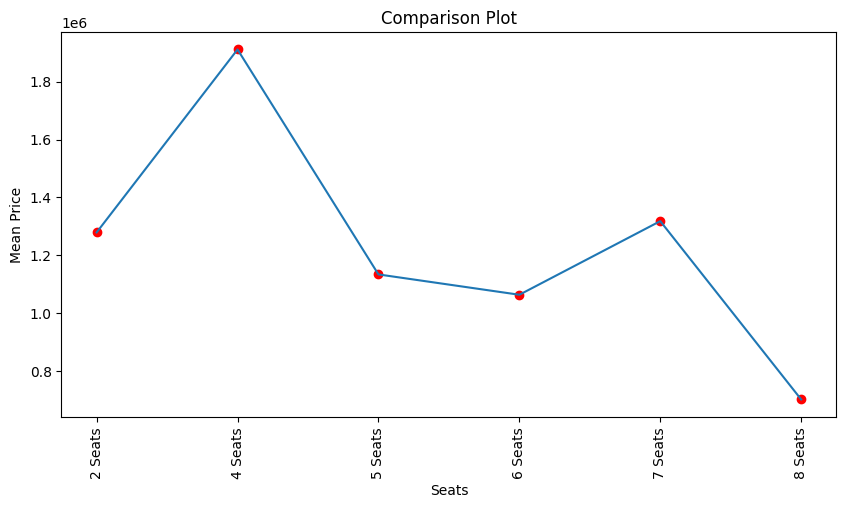

In [24]:
temp = df.groupby('Seats')[['car_prices_in_rupee']]
temp = temp.agg({'car_prices_in_rupee':np.mean})
plt.figure(figsize=(10,5))
plt.plot(temp.index,temp.values)
plt.scatter(temp.index,temp.values,c='red')
plt.xticks(rotation=90)
plt.xlabel('Seats')
plt.ylabel('Mean Price')
plt.title('Comparison Plot')
plt.show()

In [25]:
df['Seats']=df['Seats'].str[:1].astype(int)
df['engine']=df['engine'].str.replace(' cc','').astype(int)
df["ownership"] = df["ownership"].str[:1].astype(int)
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand
0,Compass 2.0 Longitude Option BSIV,1002999,86226,Diesel,Manual,1,2017,1956,5,Jeep
1,Duster RXZ Turbo CVT,1283000,13248,Petrol,Automatic,1,2021,1330,5,Renault
2,Camry 2.5 G,1639999,60343,Petrol,Automatic,1,2016,2494,5,Toyota
3,Jazz VX CVT,777000,26696,Petrol,Automatic,1,2018,1199,5,Honda
4,Polo 1.2 MPI Highline,515000,69414,Petrol,Manual,1,2016,1199,5,Volkswagen


In [26]:
df.dtypes

car_name               string
car_prices_in_rupee     int64
kms_driven              int64
fuel_type              string
transmission           string
ownership               int64
manufacture             int64
engine                  int64
Seats                   int64
brand                  string
dtype: object

In [27]:
len(df['brand'].unique())

32

In [28]:
df[df['engine']==0]

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand
288,Nexon EV Prime XZ Plus LUX,418000,24374,Electric,Automatic,1,2021,0,5,Tata
311,e2o T2,321000,54112,Electric,Automatic,1,2014,0,5,Mahindra
630,X1 sDrive 20d xLine,4375000,22000,Diesel,Automatic,1,2020,0,5,BMW
746,Wagon R VXI BS IV,236000,100527,Petrol,Manual,1,2012,0,5,Maruti
1212,Harrier XM,1260000,33500,Diesel,Manual,1,2019,0,5,Tata
1548,KWID Climber 1.0 AMT BSIV,470000,30000,Petrol,Automatic,1,2019,0,5,Renault
1758,City i-VTEC CVT VX,950000,65855,Petrol,Automatic,1,2019,0,5,Honda
1944,City E,300000,77132,Petrol,Manual,1,2012,0,5,Honda
1968,Seltos HTE D,1182000,35343,Diesel,Manual,1,2021,0,5,Kia
2175,CR-V 2.0L 2WD AT,1550000,74000,Petrol,Automatic,1,2016,0,7,Honda


In [29]:
print("min:",df[df["engine"]!=0]["engine"].min(),"\nmax:",df["engine"].max())

min: 624 
max: 5950


In [30]:
df['engine_class'] = 0
for i,size in enumerate (df["engine"]):
    if size == 0:
        df["engine_class"][i] = 0
    elif size <=1200:
        df["engine_class"][i] = 1
    elif 1201<= size <=1800:
        df["engine_class"][i] = 2
    elif 1801<= size <=2400:
        df["engine_class"][i] = 3
    elif 2401<= size <=3000:
        df["engine_class"][i] = 4
    elif 3001<= size <=4200:
        df["engine_class"][i] = 5
    elif 4201<= size <=5400:
        df["engine_class"][i] = 6
    elif 5401<= size <=6600:
        df["engine_class"][i] = 7
df.sample(5)

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand,engine_class
3733,Nexon 1.5 Revotorq XZ Plus,760000,34346,Diesel,Manual,1,2019,1396,5,Tata,2
2140,Virtus Highline AT,1500000,3638,Petrol,Automatic,0,2022,1498,5,Volkswagen,2
82,Ertiga VDI,525000,58000,Diesel,Manual,1,2013,1248,7,Maruti,2
4694,Eeco 5 Seater AC BSIV,315000,93009,Petrol,Manual,1,2017,1498,5,Maruti,2
4542,Verna 1.6 SX VTVT AT,650000,44000,Petrol,Automatic,2,2014,796,5,Hyundai,1


In [31]:
car_brand = {'LV1':["Toyota","Nissan","Mitsubishi","Ford","Hyundai","Isuzu","Honda","Datsun","Fiat","Kia","MG","Mahindra","Maruti","Premier","Tata","Renault","Force"],
             'LV2':["Jeep","Lexus","Mini","Skoda","Volkswagen","Volvo"],
             'LV3':["Audi","BMW","Chevrolet","Jaguar","Land","Mercedes-Benz","Porsche"],
             'LV4':["Bentley","Maserati"]}

df['brand_lv'] = 0
for i,brand in enumerate (df["brand"]):
    if brand in car_brand['LV1']:
        df["brand_lv"][i] = 0
    elif brand in car_brand['LV2']:
        df["brand_lv"][i] = 1
    elif brand in car_brand['LV3']:
        df["brand_lv"][i] = 2
    elif brand in car_brand['LV4']:
        df["brand_lv"][i] = 3
    else:
        print(brand)

df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand,engine_class,brand_lv
0,Compass 2.0 Longitude Option BSIV,1002999,86226,Diesel,Manual,1,2017,1956,5,Jeep,3,1
1,Duster RXZ Turbo CVT,1283000,13248,Petrol,Automatic,1,2021,1330,5,Renault,2,0
2,Camry 2.5 G,1639999,60343,Petrol,Automatic,1,2016,2494,5,Toyota,4,0
3,Jazz VX CVT,777000,26696,Petrol,Automatic,1,2018,1199,5,Honda,1,0
4,Polo 1.2 MPI Highline,515000,69414,Petrol,Manual,1,2016,1199,5,Volkswagen,1,1


In [32]:
df["Age"] = 2023 - df["manufacture"]
df.head()

,car_name,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,manufacture,engine,Seats,brand,engine_class,brand_lv,Age
0,Compass 2.0 Longitude Option BSIV,1002999,86226,Diesel,Manual,1,2017,1956,5,Jeep,3,1,6
1,Duster RXZ Turbo CVT,1283000,13248,Petrol,Automatic,1,2021,1330,5,Renault,2,0,2
2,Camry 2.5 G,1639999,60343,Petrol,Automatic,1,2016,2494,5,Toyota,4,0,7
3,Jazz VX CVT,777000,26696,Petrol,Automatic,1,2018,1199,5,Honda,1,0,5
4,Polo 1.2 MPI Highline,515000,69414,Petrol,Manual,1,2016,1199,5,Volkswagen,1,1,7


In [33]:
df.drop(['manufacture','engine','brand','car_name'],axis=1,inplace=True)
df.head()

,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,Seats,engine_class,brand_lv,Age
0,1002999,86226,Diesel,Manual,1,5,3,1,6
1,1283000,13248,Petrol,Automatic,1,5,2,0,2
2,1639999,60343,Petrol,Automatic,1,5,4,0,7
3,777000,26696,Petrol,Automatic,1,5,1,0,5
4,515000,69414,Petrol,Manual,1,5,1,1,7


In [34]:
df["brand_lv"]= df["brand_lv"].astype(int)
df["Age"]= df["Age"].astype(int)
df["engine_class"]= df["engine_class"].astype(int)
df.dtypes

car_prices_in_rupee     int64
kms_driven              int64
fuel_type              string
transmission           string
ownership               int64
Seats                   int64
engine_class            int64
brand_lv                int64
Age                     int64
dtype: object

Manual       3962
Automatic    1550
Name: transmission, dtype: Int64
----------------------------------------------------------------------------------------------------


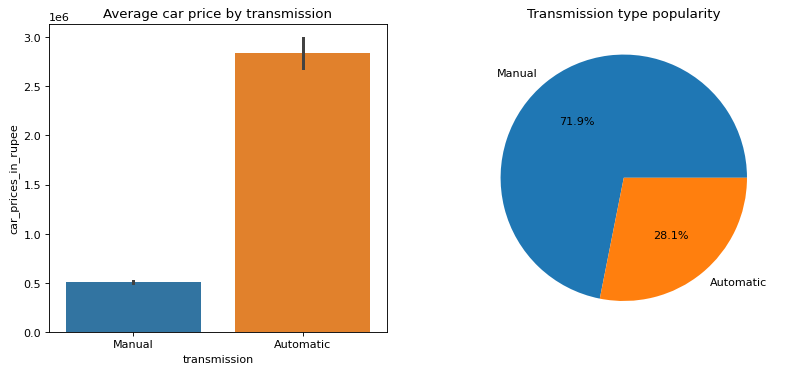

In [35]:
plt.figure(figsize=(12, 5), dpi=80)
plt.subplot(1, 2, 1)
ax = sns.barplot(x="transmission", y='car_prices_in_rupee', data=df)
ax.set_title('Average car price by transmission')

trans = df["transmission"].copy()
count = trans.value_counts()
print(count)
print('-'*100)
plt.subplot(1, 2, 2)
plt.pie(x=count,autopct='%.1f%%',labels = ["Manual","Automatic"])
plt.title('Transmission type popularity')
plt.show()

8      54
7     631
6      61
5    4673
4      88
2       5
Name: Seats, dtype: int64
----------------------------------------------------------------------------------------------------


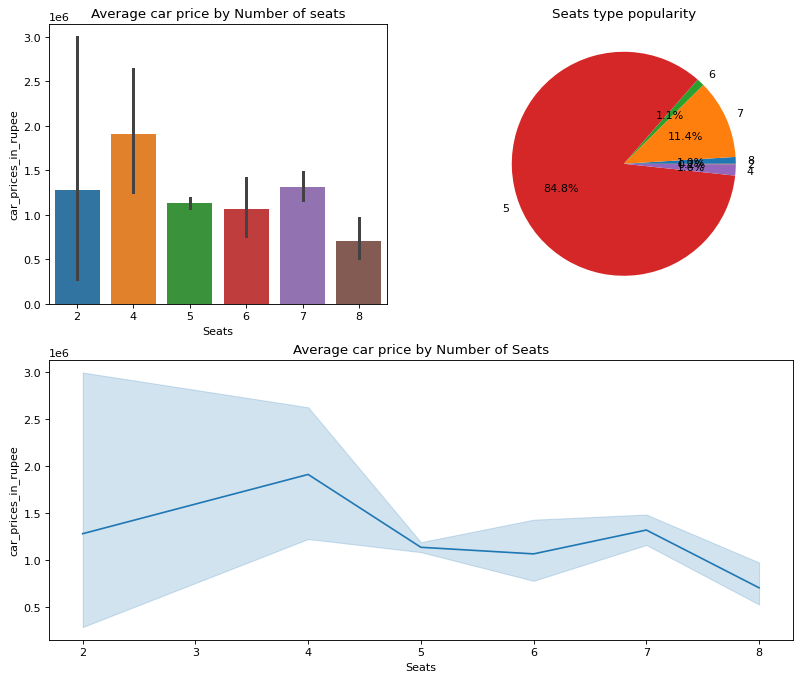

In [36]:
plt.figure(figsize=(12, 10), dpi=80)

plt.subplot(2, 1, 2)
ax1= sns.lineplot(x="Seats", y='car_prices_in_rupee', data=df)
ax1.set_title('Average car price by Number of Seats')

plt.subplot(2, 2, 1)
ax2 = sns.barplot(x="Seats", y='car_prices_in_rupee', data=df)
ax2.set_title('Average car price by Number of seats')

seat = df["Seats"].copy()
count = seat.value_counts().sort_index(ascending=False)
print(count)
print('-'*100)
plt.subplot(2, 2, 2)
plt.pie(x=count,autopct='%.1f%%',labels = ["8","7","6","5","4","2"])
plt.title('Seats type popularity')
plt.show()

5      12
4      84
3     359
2    1314
1    3736
0       7
Name: ownership, dtype: int64
----------------------------------------------------------------------------------------------------


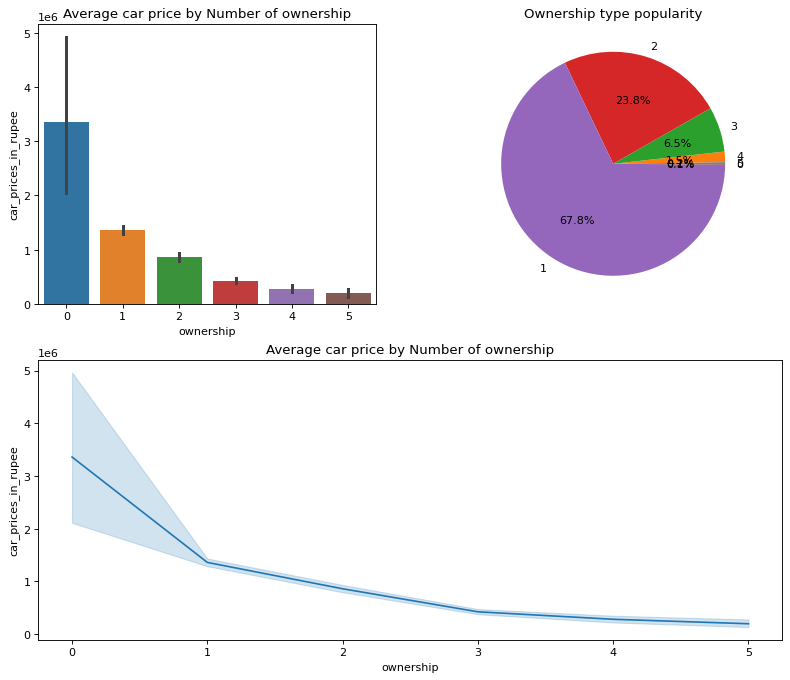

In [37]:
plt.figure(figsize=(12, 10), dpi=80)

plt.subplot(2, 1, 2)
pv2=sns.lineplot(x="ownership", y='car_prices_in_rupee', data=df)
pv2.set_title('Average car price by Number of ownership')

plt.subplot(2, 2, 1)
ax = sns.barplot(x="ownership", y='car_prices_in_rupee', data=df)
ax.set_title('Average car price by Number of ownership')

ownership = df["ownership"].copy()
count = ownership.value_counts().sort_index(ascending=False)
print(count)
print('-'*100)
plt.subplot(2, 2, 2)
plt.pie(x=count,autopct='%.1f%%',labels = ["5","4","3","2","1","0"])
plt.title('Ownership type popularity')
plt.show()

Petrol      2967
Lpg           28
Electric      14
Diesel      2423
Cng           80
Name: fuel_type, dtype: Int64
----------------------------------------------------------------------------------------------------


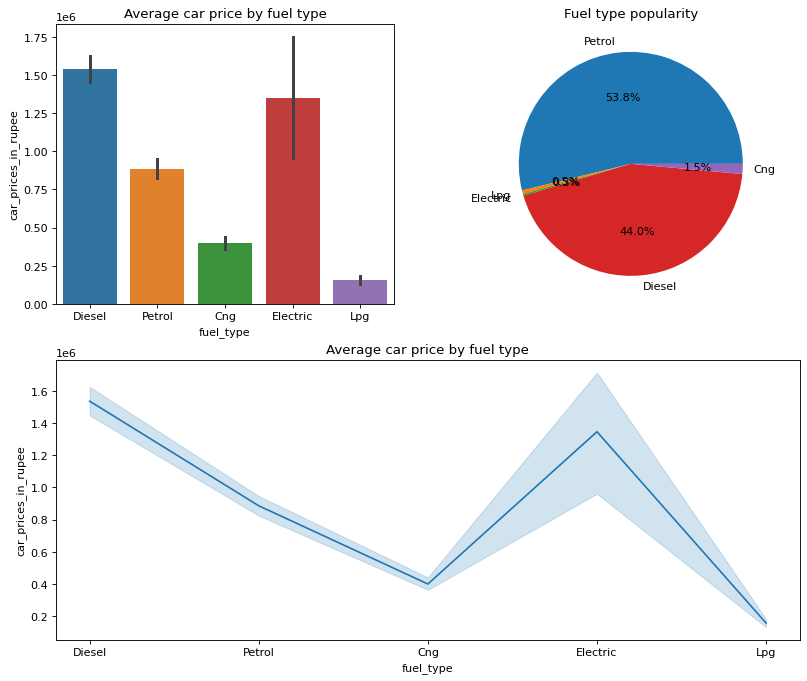

In [38]:
plt.figure(figsize=(12, 10), dpi=80)

plt.subplot(2, 1, 2)
ax = sns.lineplot(x="fuel_type", y='car_prices_in_rupee', data=df)
ax.set_title('Average car price by fuel type')

plt.subplot(2, 2, 1)
ax = sns.barplot(x="fuel_type", y='car_prices_in_rupee', data=df)
ax.set_title('Average car price by fuel type')

fuel = df["fuel_type"].copy()
count = fuel.value_counts().sort_index(ascending=False)
print(count)
print('-'*100)
plt.subplot(2, 2, 2)
plt.pie(x=count,autopct='%.1f%%',labels = ["Petrol","Lpg","Electric","Diesel","Cng"])
plt.title('Fuel type popularity')
plt.show()

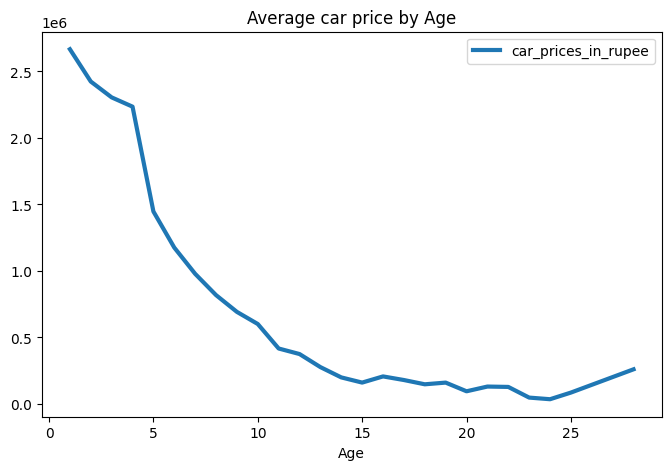

In [39]:
pv1=pd.pivot_table(df, index=['Age'],values = ['car_prices_in_rupee'],aggfunc = 'mean')
pv1.plot(kind='line',linewidth=3,figsize=(8,5),title='Average car price by Age')
plt.show()

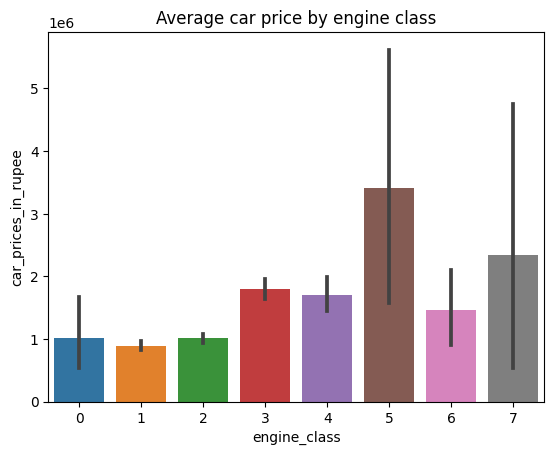

In [40]:
ax = sns.barplot(x="engine_class", y='car_prices_in_rupee', data=df)
ax.set_title('Average car price by engine class')
plt.show()

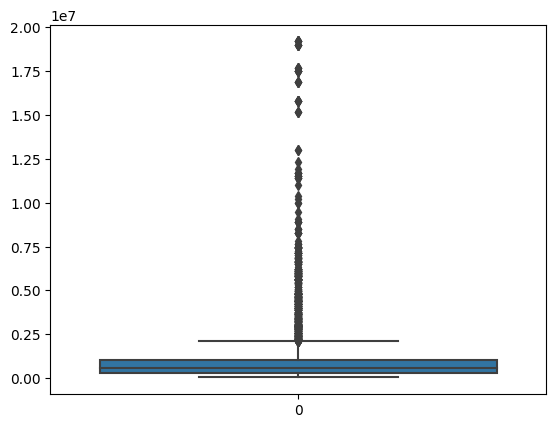

In [41]:
sns.boxplot(df['car_prices_in_rupee'])
plt.show()

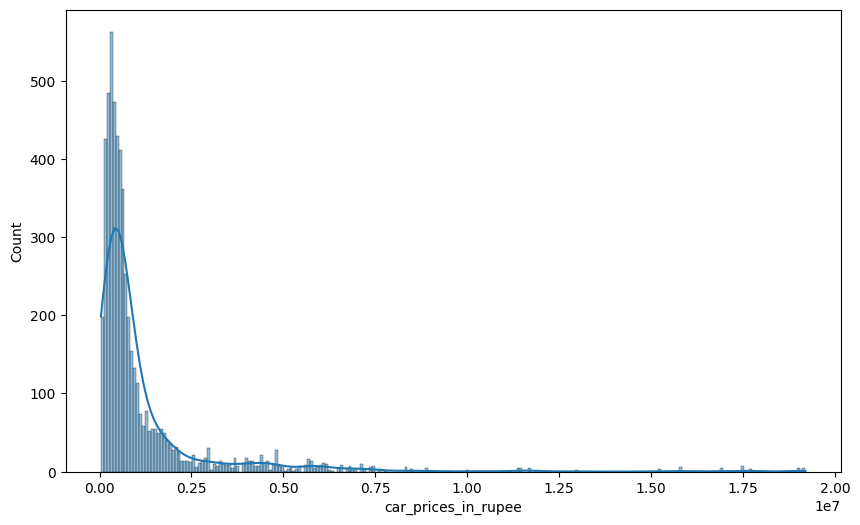

In [42]:
plt.figure(figsize=(10,6))
sns.histplot(df['car_prices_in_rupee'],kde=True)
plt.show()

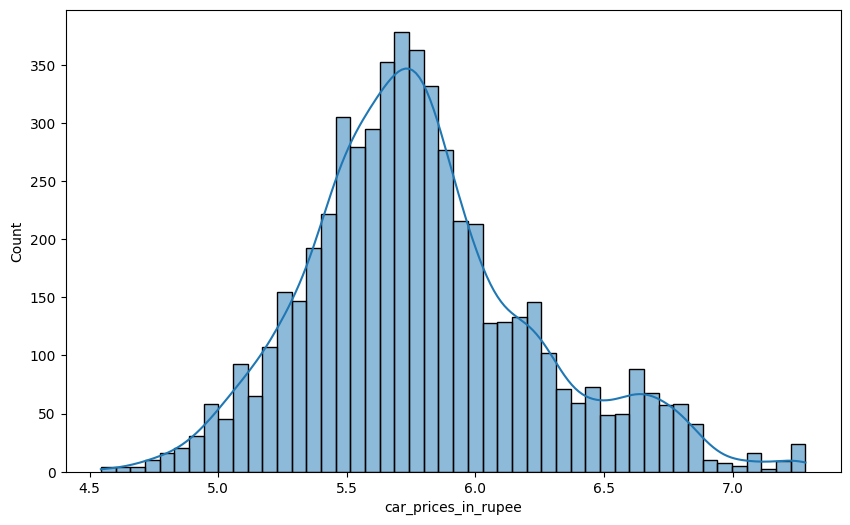

In [43]:
plt.figure(figsize=(10,6))
sns.histplot(np.log10(1 + df['car_prices_in_rupee']),kde=True)
plt.show()

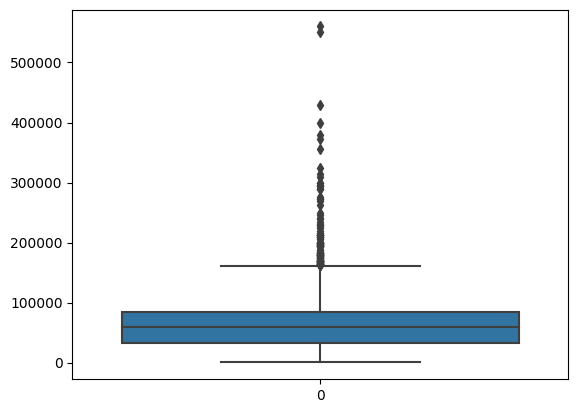

In [44]:
sns.boxplot(df['kms_driven'])
plt.show()

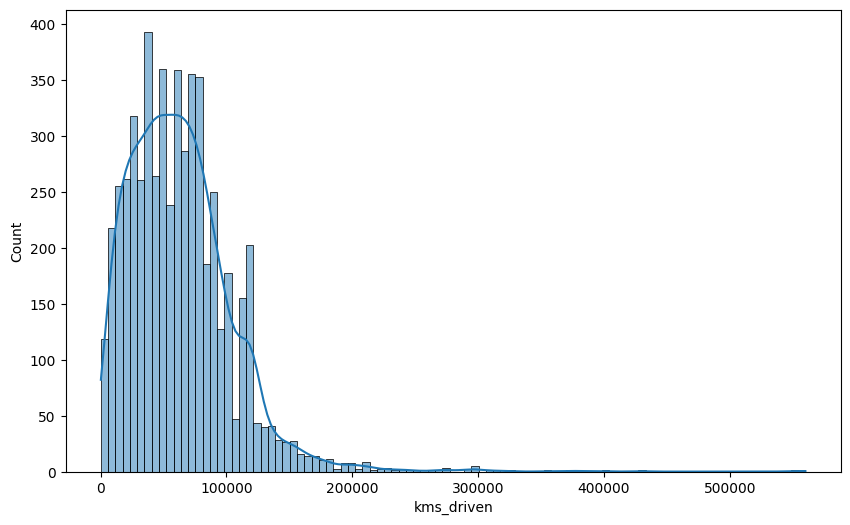

In [45]:
plt.figure(figsize=(10,6))
sns.histplot(df['kms_driven'],kde=True)
plt.show()

In [46]:
df['kms_driven'] = np.log10(1 + df['kms_driven'])
df.head()

,car_prices_in_rupee,kms_driven,fuel_type,transmission,ownership,Seats,engine_class,brand_lv,Age
0,1002999,4.935643,Diesel,Manual,1,5,3,1,6
1,1283000,4.122183,Petrol,Automatic,1,5,2,0,2
2,1639999,4.780634,Petrol,Automatic,1,5,4,0,7
3,777000,4.426462,Petrol,Automatic,1,5,1,0,5
4,515000,4.841453,Petrol,Manual,1,5,1,1,7


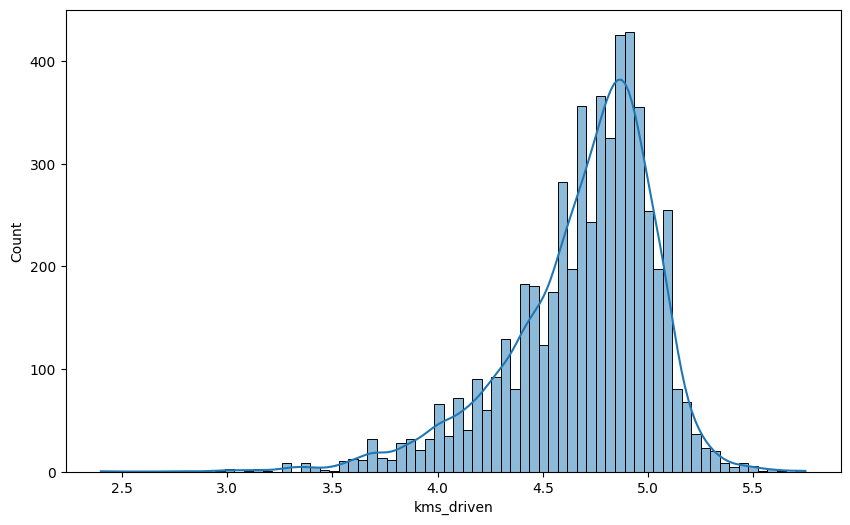

In [47]:
plt.figure(figsize=(10,6))
sns.histplot(df['kms_driven'],kde=True)
plt.show()

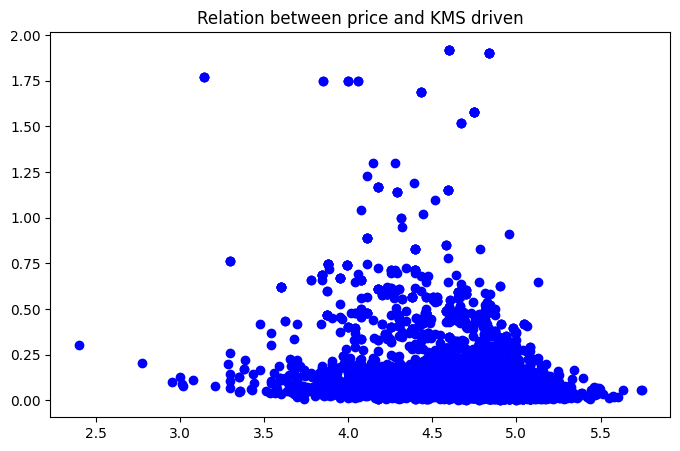

In [48]:
plt.figure(figsize=(8,5))
plt.title('Relation between price and KMS driven')
plt.scatter(np.array(df['kms_driven']),np.array(df['car_prices_in_rupee'])/10000000,color="b")
plt.show()

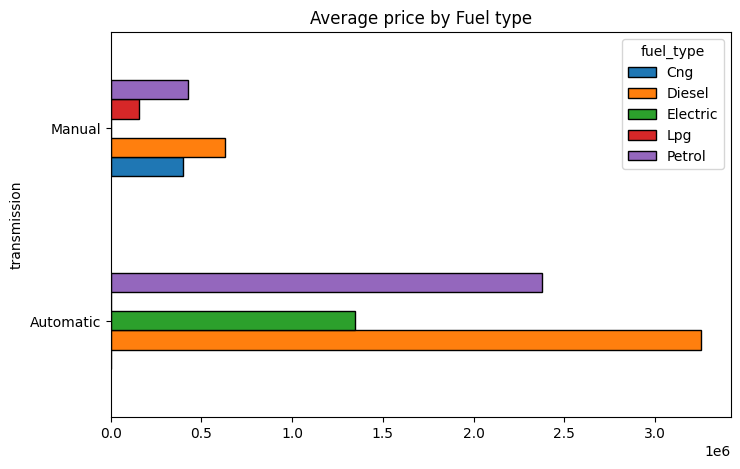

In [49]:
transm=pd.pivot_table(df,index='transmission',values='car_prices_in_rupee',columns='fuel_type')
transm.plot(kind='barh',figsize=(8,5),edgecolor = 'black',title='Average price by Fuel type')
plt.show()

In [50]:
df = pd.get_dummies(data=df, columns=['fuel_type'])
df["transmission"] = df["transmission"].map({"Manual":0,"Automatic":1})
df.head()

,car_prices_in_rupee,kms_driven,transmission,ownership,Seats,engine_class,brand_lv,Age,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,fuel_type_Petrol
0,1002999,4.935643,0,1,5,3,1,6,0,1,0,0,0
1,1283000,4.122183,1,1,5,2,0,2,0,0,0,0,1
2,1639999,4.780634,1,1,5,4,0,7,0,0,0,0,1
3,777000,4.426462,1,1,5,1,0,5,0,0,0,0,1
4,515000,4.841453,0,1,5,1,1,7,0,0,0,0,1


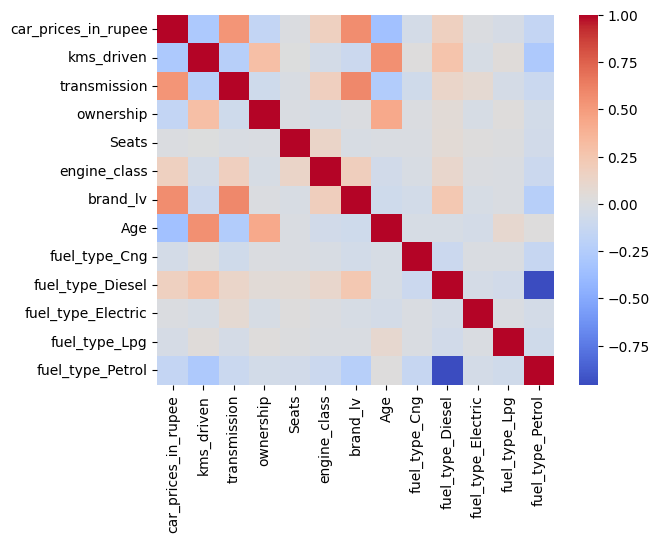

In [51]:
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

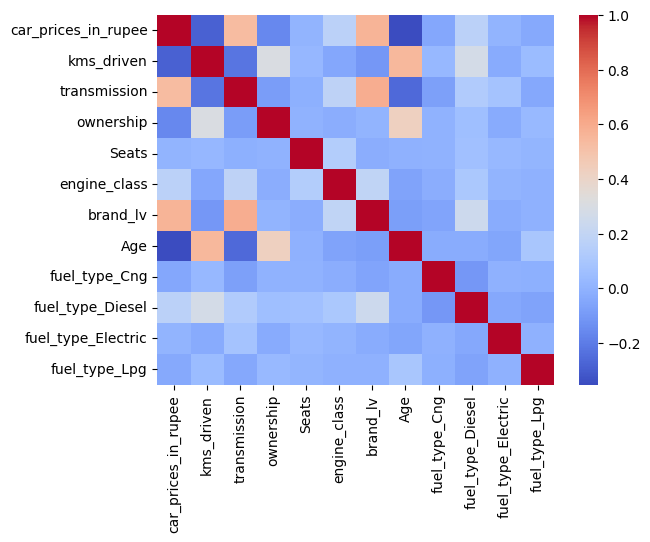

In [52]:
df.drop('fuel_type_Petrol',axis=1,inplace=True)
sns.heatmap(df.corr(), cmap='coolwarm')
plt.show()

In [53]:
df.shape

(5512, 12)

In [54]:
factor = 10**5

In [55]:
df['prices'] = df['car_prices_in_rupee']/factor
df.head()

,car_prices_in_rupee,kms_driven,transmission,ownership,Seats,engine_class,brand_lv,Age,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,prices
0,1002999,4.935643,0,1,5,3,1,6,0,1,0,0,10.02999
1,1283000,4.122183,1,1,5,2,0,2,0,0,0,0,12.83000
2,1639999,4.780634,1,1,5,4,0,7,0,0,0,0,16.39999
3,777000,4.426462,1,1,5,1,0,5,0,0,0,0,7.77000
4,515000,4.841453,0,1,5,1,1,7,0,0,0,0,5.15000


In [56]:
df.drop('car_prices_in_rupee',axis=1,inplace=True)
df.head()

,kms_driven,transmission,ownership,Seats,engine_class,brand_lv,Age,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,prices
0,4.935643,0,1,5,3,1,6,0,1,0,0,10.02999
1,4.122183,1,1,5,2,0,2,0,0,0,0,12.83000
2,4.780634,1,1,5,4,0,7,0,0,0,0,16.39999
3,4.426462,1,1,5,1,0,5,0,0,0,0,7.77000
4,4.841453,0,1,5,1,1,7,0,0,0,0,5.15000


In [57]:
X = df.drop('prices',axis=1)
X.head()

,kms_driven,transmission,ownership,Seats,engine_class,brand_lv,Age,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg
0,4.935643,0,1,5,3,1,6,0,1,0,0
1,4.122183,1,1,5,2,0,2,0,0,0,0
2,4.780634,1,1,5,4,0,7,0,0,0,0
3,4.426462,1,1,5,1,0,5,0,0,0,0
4,4.841453,0,1,5,1,1,7,0,0,0,0


In [58]:
y = df['prices']
y.head()

0    10.02999
1    12.83000
2    16.39999
3     7.77000
4     5.15000
Name: prices, dtype: float64

In [59]:
df.dtypes

kms_driven            float64
transmission            int64
ownership               int64
Seats                   int64
engine_class            int64
brand_lv                int64
Age                     int64
fuel_type_Cng           uint8
fuel_type_Diesel        uint8
fuel_type_Electric      uint8
fuel_type_Lpg           uint8
prices                float64
dtype: object

**Machine Learning**

In [60]:
X = np.array(X)
print(X)
print(X.shape)

[[4.93564328 0.         1.         ... 1.         0.         0.        ]
 [4.1221831  1.         1.         ... 0.         0.         0.        ]
 [4.78063409 1.         1.         ... 0.         0.         0.        ]
 ...
 [4.95424733 1.         2.         ... 1.         0.         0.        ]
 [4.89763259 1.         3.         ... 1.         0.         0.        ]
 [4.62325963 1.         2.         ... 1.         0.         0.        ]]
(5512, 11)


In [61]:
y = np.array(y)
print(y)
print(y.shape)

[10.02999 12.83    16.39999 ... 13.75    29.9     31.9    ]
(5512,)


In [62]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4409, 11)
(1103, 11)
(4409,)
(1103,)


In [63]:
def adj_r2(y,y_pred):
  return (1 - (1-r2_score(y, y_pred)) * (len(y)-1)/(len(y)-11-1)) # Here 11 is for number of independent variables or x.shape[1]

In [64]:
models = [['KNN',KNeighborsRegressor()],['Random Forest',RandomForestRegressor()],['SVM',SVR()],
          ['XGB',XGBRegressor()]]

In [65]:
def training_perf(model, x_train, y_train):
    model = model.fit(x_train,y_train)
    y_pred = model.predict(x_train)

    print('Predicted Values: ',y_pred)
    print('Mean squared error: ',mean_squared_error(y_train,y_pred))
    print('Mean absolute error: ',mean_absolute_error(y_train,y_pred))
    print('Adjusted R-squared score: ',adj_r2(y_train,y_pred))

In [66]:
for x in models:
    print(x[0],':\n')
    training_perf(x[1],x_train,y_train)
    print('-'*50)

KNN :

Predicted Values:  [11.99   8.65   0.708 ...  8.558 42.3    1.78 ]
Mean squared error:  96.09015128950607
Mean absolute error:  3.7047771644363805
Adjusted R-squared score:  0.749326148112865
--------------------------------------------------
Random Forest :

Predicted Values:  [12.4031998  6.1649     0.4592    ...  6.721     46.902      1.7924   ]
Mean squared error:  9.64289079419207
Mean absolute error:  1.2991029101689286
Adjusted R-squared score:  0.9748442421385687
--------------------------------------------------
SVM :

Predicted Values:  [16.74780222  9.60244236  1.13314557 ...  7.56420628 32.07311656
  1.58392262]
Mean squared error:  230.85011569848635
Mean absolute error:  5.084006280539652
Adjusted R-squared score:  0.3977729566021605
--------------------------------------------------
XGB :

Predicted Values:  [12.742676   7.540168   1.2635316 ...  5.8742404 44.386917   1.8067976]
Mean squared error:  10.768447319123528
Mean absolute error:  1.8410384508705486
Adjus

In [67]:
def cross(model,x_train,y_train):
    kfold = KFold(n_splits=10)
    results = cross_val_score(model,x_train,y_train,cv=kfold,scoring='neg_mean_squared_error')
    print('Individual Results: ',results, '\n\n Mean: ', results.mean(), '\n\n Standard Deviation: ',results.std())

In [68]:
for x in models:
    print(x[0],':\n')
    cross(x[1],x_train,y_train)
    print('-'*50)

KNN :

Individual Results:  [-213.7016873  -145.1624314  -165.78173458 -193.97762761 -138.68920248
  -69.31545659 -124.72776469 -116.1604447  -153.9050648  -133.99159624] 

 Mean:  -145.54130103997298 

 Standard Deviation:  38.417250729255784
--------------------------------------------------
Random Forest :

Individual Results:  [ -72.39441914 -109.3342391   -72.61995161 -127.84580413  -44.96874383
  -41.23437793  -56.30817414  -36.1466621   -47.12842243  -69.99267775] 

 Mean:  -67.79734721461263 

 Standard Deviation:  28.579797958740016
--------------------------------------------------
SVM :

Individual Results:  [-247.04861201 -241.75676354 -256.39366484 -313.15671741 -190.09903034
 -181.94777796 -187.90728055 -192.38506631 -269.17915801 -262.37291055] 

 Mean:  -234.22469815166218 

 Standard Deviation:  41.87225400975942
--------------------------------------------------
XGB :

Individual Results:  [ -64.734451   -104.9067569   -58.31732112 -120.57249043  -45.29273372
  -59.43



**- Baseline scores for rough comparison of models:**
  
> KNN:

* Mean squared error: 96.09015128950607
* Mean absolute error: 3.7047771644363805
* Adjusted R-squared score: 0.749326148112865
* Mean CV score: -145.54130103997298
* CV Standard deviation: 38.417250729255784

> Random Forest:

* Mean squared error: 9.64289079419207
* Mean absolute error: 1.2991029101689286
* Adjusted R-squared score: 0.9748442421385687
* Mean score: -67.79734721461263
* Standard deviation: 28.579797958740016

> SVM:

* Mean squared error: 230.85011569848635
* Mean absolute error: 5.084006280539652
* Adjusted R-squared score: 0.3977729566021605
* Mean score: -234.22469815166218
* Standard deviation: 41.87225400975942

> XGB:

* Mean squared error: 10.768447319123528
* Mean absolute error: 1.8410384508705486
* Adjusted R-squared score: 0.9719079621365609
* Mean score: -68.10803491709747
* Standard deviation: 29.517783447804593

>  The models  **KNN**, **RandomForest** and **XGB** have the lowest **neg_mse** score with comparatively small standard deviations. These models also have lower training errors and higher r2 score compared to SVM. This suggests that these models will generalize well on new data. So, we will focus more on these 3 models.

In [69]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size = 0.2, random_state=42)
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(3527, 11)
(882, 11)
(1103, 11)
(3527,)
(882,)
(1103,)


In [74]:
def random(model,x_train,x_valid,y_train,y_valid,params):
    rand = RandomizedSearchCV(model,param_distributions=params,scoring='neg_mean_squared_error',n_iter=20,n_jobs=-1,cv=2,verbose=1)
    rand = rand.fit(x_train,y_train)

    print('Best Parameters: ',rand.best_params_)
    print('\nBest Estimator: ',rand.best_estimator_)
    print('\nBest score: ',rand.best_score_)

    best_model = rand.best_estimator_
    best_models.append(best_model)
    best_model = best_model.fit(x_train, y_train)

    print('\nTraining scores:')
    y_pred_train = best_model.predict(x_train)
    print('Mean squared error: ',mean_squared_error(y_train,y_pred_train))
    print('Mean absolute error: ',mean_absolute_error(y_train,y_pred_train))
    print('Adjusted R-squared score: ',adj_r2(y_train,y_pred_train))

    print('\nValidation scores:')
    y_pred_valid = best_model.predict(x_valid)
    print('Mean squared error: ',mean_squared_error(y_valid,y_pred_valid))
    print('Mean absolute error: ',mean_absolute_error(y_valid,y_pred_valid))
    print('Adjusted R-squared score: ',adj_r2(y_valid,y_pred_valid))

In [71]:
knn_params = {'n_neighbors': [3,5,7,9],'weights':['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree'],'p':[1,2]}
svm_params = {'kernel':['rbf'],'gamma':[.1,.5,1,2,5,10],'C':[.1,1,10,100,1000]}
rf_params = {
            'criterion':['squared_error', 'absolute_error', 'friedman_mse'],
            'bootstrap':[True,False],
            'max_depth':[3,5,10,20,50,75,100,None],
            'min_samples_leaf':[1,2,4,10],
            'min_samples_split':[2,5,10]
}
xgb_params = {
    'n_estimators':[20,50,100,250,500,1000],
    'colsample_bytree':[0.2,0.5,0.7,0.8,1],
    'max_depth':[2,5,10,15,20,25,None],
    'reg_alpha':[0,0.5,1],
    'reg_lambda':[1,1.5,2],
    'learning_rate':[0.01,0.03,0.1,0.3,1,3,10],
    'subsample':[0.5,0.6,0.7,0.8,0.9],
    'gamma':[0,0.01,0.1,1,10,100],
    'min_child_weight':[0,0.01,0.1,1,10,100],
    'sampling_method':['uniform','gradient_based']
}

In [72]:
models_rand = [['KNN',KNeighborsRegressor(),knn_params],['Random Forest',RandomForestRegressor(),rf_params],['SVM',SVR(),svm_params],
          ['XGB',XGBRegressor(),xgb_params]]

In [75]:
best_models = []

for x in models_rand:
    print(x[0],':\n')
    random(x[1],x_train,x_valid,y_train,y_valid,x[2])
    print('-'*50)

KNN :

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Parameters:  {'weights': 'uniform', 'p': 2, 'n_neighbors': 7, 'algorithm': 'auto'}

Best Estimator:  KNeighborsRegressor(n_neighbors=7)

Best score:  -172.8905254414724

Training scores:
Mean squared error:  120.07131389039918
Mean absolute error:  4.054819228806351
Adjusted R-squared score:  0.6984656351487212

Validation scores:
Mean squared error:  102.84496811048938
Mean absolute error:  4.274951289277616
Adjusted R-squared score:  0.6779355009996417
--------------------------------------------------
Random Forest :

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best Parameters:  {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 75, 'criterion': 'squared_error', 'bootstrap': True}

Best Estimator:  RandomForestRegressor(max_depth=75, min_samples_leaf=4)

Best score:  -157.18099048631618

Training scores:
Mean squared error:  64.66772703855003
Mean absolute error:  3.0648812334830833
A

**- KNN**

> Mean Squared Error:

*   Best Training error: 120.07131389039918
*   Best validation error: 102.84496811048938

> Mean Absolute Error:

*   Best Training error: 4.054819228806351
*   Best validation error: 4.274951289277616

> Adjusted R-squared:

*   Best Training score: 0.6984656351487212
*   Best validation score: 0.6779355009996417

**- SVM**

> Mean Squared Error:

*   Best Training error: 162.4970691307246
*   Best validation error: 122.0602193215284

> Mean Absolute Error:

*   Best Training error: 3.6043580647202282
*   Best validation error: 3.9403882494312525

> Adjusted R-squared:

*   Best Training score: 0.591922092438723
*   Best validation score: 0.6177619177106588

**- Random Forest**

> Mean Squared Error:

*   Best Training error: 64.66772703855003
*   Best validation error: 57.37165807473717

> Mean Absolute Error:

*   Best Training error: 3.0648812334830833
*   Best validation error: 3.423878779167546

> Adjusted R-squared:

*   Best Training score: 0.8376003279455725
*   Best validation score: 0.8203375949826801

**- XGB**

> Mean Squared Error:

*   Best Training error: 24.82964257661872
*   Best validation error: 57.886709757646706

> Mean Absolute Error:

*   Best Training error: 2.6720570367504597
*   Best validation error: 3.7506542468797974

> Adjusted R-squared:

*   Best Training score: 0.9376454686699014
*   Best validation score: 0.8187246831867686

> Here best scores indicate scores measured after creating the validation split (i.e. working on a reduced dataset) and after hyperparameter tuning is performed on the models using **RandomizedSearchCV**. Looking at all the performance measuring parameters here, we can safely conclude that the model **RandomForest** performed the best.

> **KNN** and **SVM** have high training and validation errors compared to **RandomForest** and **XGB**. Therefore, these two models are out of the picture.

> **RandomForest** and **XGB** have comparable validation errors, however XGB has a very low training error but a high validation error. This suggests that **XGB** is probably suffering from a case of **overfitting** or **high variance**.

> Compared to **XGB**, **RandomForest** has a higher training error, but the difference between the training and validation errors of **RandomForest** is small, and the absolute values of errors are also small, which suggests that this model is neither overfitting nor underfitting and the fitting is just right. So, this model will generalize well on new data and thus, is the best choice for our data.

In [76]:
best_models

[KNeighborsRegressor(n_neighbors=7),
 RandomForestRegressor(max_depth=75, min_samples_leaf=4),
 SVR(C=100, gamma=0.1),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=100, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)]

In [78]:
best_rf = best_models[1].fit(x_train,y_train)
y_pred_rf = best_rf.predict(x_test)
print('Mean squared error: ',mean_squared_error(y_test,y_pred_rf))
print('Mean absolute error: ',mean_absolute_error(y_test,y_pred_rf))
print('Adjusted R-squared score: ',adj_r2(y_test,y_pred_rf))

Mean squared error:  112.21676211603601
Mean absolute error:  4.167944875757148
Adjusted R-squared score:  0.7185439280463535


In [79]:
best_xgb = best_models[3].fit(x_train,y_train)
y_pred_xgb = best_xgb.predict(x_test)
print('Mean squared error: ',mean_squared_error(y_test,y_pred_xgb))
print('Mean absolute error: ',mean_absolute_error(y_test,y_pred_xgb))
print('Adjusted R-squared score: ',adj_r2(y_test,y_pred_xgb))

Mean squared error:  81.60667246856944
Mean absolute error:  4.117137696572472
Adjusted R-squared score:  0.7953185152993372


> Here we see that **XGB** performs better than **RandomForest** on unseen data. However, we also saw that **XGB** is overfitting. So to finally add our predicted data to our dataset, we will add both the results. The important thing to note here is that as per our analysis, we must only consider result from **RandomForest**. However, due to the limitation of my device and to reduce the time it took to execute the code, I had to significantly reduce the number of iterations in the hyperparameter tuning step. If these iterations were performed for a considerable number of times, we might have had different result, i.e. probably **XGB** would have performed better because overall, **XGB** is the best model that we have in our sklearn arsenal. So, these results and analysis are to be taken with a grain of salt.

In [80]:
df.head()

,kms_driven,transmission,ownership,Seats,engine_class,brand_lv,Age,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,prices
0,4.935643,0,1,5,3,1,6,0,1,0,0,10.02999
1,4.122183,1,1,5,2,0,2,0,0,0,0,12.83000
2,4.780634,1,1,5,4,0,7,0,0,0,0,16.39999
3,4.426462,1,1,5,1,0,5,0,0,0,0,7.77000
4,4.841453,0,1,5,1,1,7,0,0,0,0,5.15000


In [85]:
df.head()

,kms_driven,transmission,ownership,Seats,engine_class,brand_lv,Age,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,prices
0,4.935643,0,1,5,3,1,6,0,1,0,0,10.02999
1,4.122183,1,1,5,2,0,2,0,0,0,0,12.83000
2,4.780634,1,1,5,4,0,7,0,0,0,0,16.39999
3,4.426462,1,1,5,1,0,5,0,0,0,0,7.77000
4,4.841453,0,1,5,1,1,7,0,0,0,0,5.15000


In [86]:
df['Random_Forest_Price_Prediction'] = best_rf.predict(df.iloc[:,:-1])
df['XGB_Price_Prediction'] = best_xgb.predict(df.iloc[:,:-2])
df.head()

,kms_driven,transmission,ownership,Seats,engine_class,brand_lv,Age,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,prices,Random_Forest_Price_Prediction,XGB_Price_Prediction
0,4.935643,0,1,5,3,1,6,0,1,0,0,10.02999,9.774649,8.852035
1,4.122183,1,1,5,2,0,2,0,0,0,0,12.83000,14.213037,12.644239
2,4.780634,1,1,5,4,0,7,0,0,0,0,16.39999,11.992273,18.604507
3,4.426462,1,1,5,1,0,5,0,0,0,0,7.77000,8.353605,10.639876
4,4.841453,0,1,5,1,1,7,0,0,0,0,5.15000,4.989267,5.747009


In [87]:
for x in ['prices','Random_Forest_Price_Prediction','XGB_Price_Prediction']:
  df[x] = df[x]*factor
df.sample(10)

,kms_driven,transmission,ownership,Seats,engine_class,brand_lv,Age,fuel_type_Cng,fuel_type_Diesel,fuel_type_Electric,fuel_type_Lpg,prices,Random_Forest_Price_Prediction,XGB_Price_Prediction
2261,4.812920,0,1,5,2,0,3,0,1,0,0,850000.0,1.090775e+06,1.123101e+06
4237,4.529918,0,1,5,2,0,5,0,0,0,0,648000.0,6.394626e+05,5.617172e+05
437,4.903095,0,2,5,2,0,17,0,0,0,0,295000.0,1.406079e+05,1.748602e+05
516,4.886496,1,2,5,1,0,9,0,0,0,0,675000.0,5.932973e+05,3.926776e+05
5491,5.107213,1,2,5,3,0,7,0,1,0,0,2210000.0,1.255997e+06,1.212627e+06
1207,4.763435,0,1,5,3,0,6,0,1,0,0,699000.0,7.008946e+05,6.403436e+05
5014,4.871193,0,1,5,1,0,5,0,0,0,0,454000.0,4.937896e+05,5.577403e+05
2971,4.831991,0,1,5,2,0,7,0,1,0,0,522000.0,7.913712e+05,5.873476e+05
5395,4.903095,0,1,7,2,0,9,0,1,0,0,350000.0,5.894445e+05,5.534235e+05
1291,4.414990,1,1,7,4,0,3,0,0,0,0,1700000.0,1.931737e+06,1.614801e+06
